<p style="text-align:right;">Mario Stanke, Felix Becker, University of Greifswald, Germany</p>

# Exercise Set 3 - 1 - A <span style="color:red">Convolutional</span> Neural Network to Classify n-Gons

This notebook gives the first example of a *convolutional* neural network for the same data as before: **triangles, quadrilaterals, pentagons and hexagons.**

Step through and run all cells up to **Visualize the Filters** at the end. Follow the instructions there.

On your way, try to read and understand as much of the code as possible.

Remember that you can split cells with `CTRL` + `shift` + `-` anytime you want to check an intermediate result. Often that's the easiest way to understand what's going on.

(Don't worry to mess up the code, there is a way to revert back to default on request.)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
import pickle # to load 'pickled' numpy arrays (serialized, compressed)
from tensorflow.keras.layers import Dense, Flatten

In [2]:
# load image data as numpy arrays (generated with a separate script available on request)
# Pickling is a way to store datastructures on a drive - or cucumbers in a glass.
# load training data
with open("../data/ngons/ngon_train.pkl", "rb") as f:
    Xtrain, ytrain_class = pickle.load(f)
# load test data
with open("../data/ngons/ngon_test.pkl", "rb") as f:
    Xtest, ytest_class = pickle.load(f)
    
Xtrain = np.expand_dims(Xtrain, -1)
Xtest = np.expand_dims(Xtest, -1)

num_train = Xtrain.shape[0]
num_test = Xtest.shape[0]
height = Xtrain.shape[1]
width = Xtrain.shape[2]
img_size_flat = width * height

print("Images are", width, "by", height, "pixels and have", Xtrain.shape[3], "color channel.")

num_classes = 4 # 0, 1, 2, 3 for 3-, 4-, 5-, 6-gons

# one-hot encode output classes
ytrain = np.eye(num_classes, dtype=float)[ytrain_class]
ytest = np.eye(num_classes, dtype=float)[ytest_class]
print("Fraction of classes:", np.mean(ytrain, axis=0)) # close to 1/4 each

# normalize input to [0,1]
Xtrain = Xtrain / 255.
Xtest = Xtest / 255.

print("Size of training set is", num_train, ", size of test set is", num_test)

# Number of classes
num_classes = 4 # 0, 1, 2, 3 for 3, ..., 6 gons


Images are 32 by 32 pixels and have 1 color channel.
Fraction of classes: [0.2567 0.2409 0.2502 0.2522]
Size of training set is 10000 , size of test set is 2000


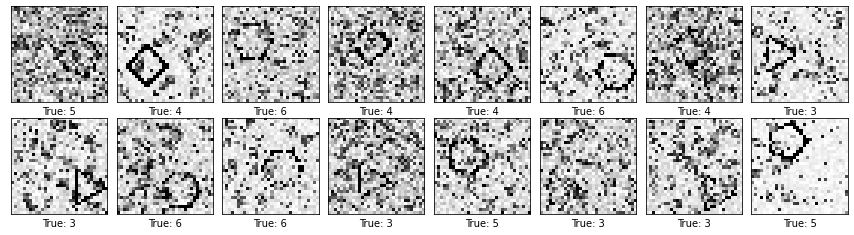

In [3]:
# Function to plot 8 images in a 2x4 grid, and writing the true and predicted classes below each image.
def plot_images(images, class_true, class_pred = None):
    """ Plot 16 (sample) images with their true and predicted classes"""
    assert len(images) == len(class_true) == 16

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.05, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], interpolation = 'none', cmap = 'binary') # plot image

        # display also true and predicted classes
        if class_pred is None:
            xlabel = "True: {0}".format(3 + class_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(3 + class_true[i], 3 + class_pred[i])

        ax.set_xlabel(xlabel)

        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])


plot_images(Xtrain[0:16], ytrain_class[0:16])

## Create a Convolutional Neural Network Model


<img src="cnn-ngon.png" alt="cnn architecture" width="800"/>



In [ ]:
# Perform the neural network training and report the model, the training history and loss and accuracy on the test set.
   
tf.random.set_seed(13032021) # so we all get the same pseudorandom results

model = tf.keras.models.Sequential()
model.add( Conv2D(filters = 8, kernel_size = (13, 13), input_shape = (height, width, 1)))
model.add( MaxPooling2D(pool_size = (20, 20)))
model.add( Conv2D(filters = 4, kernel_size = (1, 1),  activation = tf.nn.softmax))
model.add( Flatten())

model.summary()

# define the loss, optimization algorithm and prepare the model for gradient computation 
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# execute the actual training
history = model.fit(Xtrain,
                    ytrain, epochs = 20,
                    validation_split = 0.2, verbose = 1,
                    batch_size = 64) # takes ~3m on CPU, a few seconds on a RTX 3090 GPU

In [ ]:
test_loss, test_acc  = model.evaluate(Xtest, ytest, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

### Plot the training history

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.set_title('Training and validation accuracy')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
ax.set_yscale('logit')


ax.plot(epochs, acc, color = "blue", label = "training accuracy")
ax.plot(epochs, val_acc, "o:", color = "red", label = "validation accuracy")
ax.axhline(y = test_acc, color = "green", linestyle = "--", label = "test accuracy")

ax.legend();

From above plot we see that the model classifies training data siginifantly better than test data (overfit). It indicates that a model with fewer parameters or regularization could be better.

# Make and Examine Predictions

In [ ]:
ytest_pred = model(Xtest)
print("Predicted class probabilities for 3, 4, 5, 6 for the first 16 images:\n", ytest_pred[0:16].numpy().round(3))

ytest_predclass = np.argmax(ytest_pred, axis = 1)
plot_images(Xtest[0:16], ytest_class[0:16], ytest_predclass[0:16])

# Visualize the Filters (your task)
Your task is to create a figure with 8 subplots (axes), one for each filter from the first layer.
Each subplot is a visualization of a $13 \times 13$ array of real numbers. This helps to understand, what patterns the filter respond to, at least in this very simple example.

In [ ]:
# obtain the tensor of convolutional filters from the first layer 
Theta0 = model.get_weights()[0]
print(Theta0.shape)
# print the third filter as numbers
np.set_printoptions(linewidth = 100)
print(Theta0[:, :, 0, 2].round(3))

Tips: 
 - [plt.imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html) automatically scales the pixel numbers to be between 0 and 1 using the minimum and maximum pixel value of the image (i.e. the brightest pixel of each image is always white and the darkest is always black).

In [ ]:
# YOUR CODE HERE to create a plot of the filters, ~3 lines

\
\
\
\
\
\
\
\
\
\
If you are done and you've got yourself a GPU node, why not adjust the model architecture above a little bit and see if you can do something about the overfitting?